### 这是一个部署的教程，但是运行到XyloSim阶段会有各种报错，但是整体思路是有借鉴意义的


# Training a spiking network to deploy to the Xylo digital SNN

In [5]:
# -- Some useful imports

# - Time-series data
from rockpool import TSContinuous, TSEvent

# - Rich printing
try:
    from rich import print
except:
    pass

# - Numpy
import numpy as np

# - Import and configure matplotlib for plotting
import sys
!{sys.executable} -m pip install --quiet matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.dpi"] = 300

## Considerations

This notebook shows how to define a spiking model using the ``LIFTorch`` class and train it on a simple task. For simplicity, the used task is just to spike at certain times given random but fixed input.

In this case we target the Xylo hardware and have to consider the hardware constraints. I.e. the hardware has to receive spiking input, has only 16 input channels and 1000 recurrently connected neurons.

We will use Samna to create and validate a model definiton for Xylo and the use XyloSim to simulate it.

**Samna and XyloSim are required for this tutorial**


## Define a task

We will define a simple random regression task, where random frozen input noise is mapped to randomly chosen smooth output signals. We implement this using a ``Dataset``-compatible class, implementing the ``__len__()`` and ``__getitem__()`` methods.

In [6]:
import torch

# - Define a dataset class implementing the indexing interface
class MultiClassRandomSpikeTimeMapping:
    def __init__(
        self,
        num_classes: int = 2,
        sample_length: int = 100,
        input_channels: int = 50,
        target_channels: int = 2,
    ):
        # - Record task parameters
        self._num_classes = num_classes
        self._sample_length = sample_length

        # - Draw random input signals
        self._inputs = np.abs(
            np.random.randn(num_classes, sample_length, input_channels) + 1.0
        )
        self._inputs = np.round(self._inputs / np.abs(self._inputs).max() * 1)
        self._inputs = np.clip(self._inputs, 0, 1)

        # - Generate target output signals
        time_base = np.atleast_2d(np.arange(sample_length) / sample_length).T
        self._targets = np.zeros((num_classes, sample_length, target_channels))
        for c in range(num_classes):
            for i in range(target_channels):
                self._targets[
                    c,
                    np.random.choice(
                        np.arange(self._targets[c, :, i].size - 10) + 10, 1
                    ),
                    i,
                ] = 1

    def __len__(self):
        # - Return the total size of this dataset
        return self._num_classes

    def __getitem__(self, i):
        # - Return the indexed dataset sample
        return torch.Tensor(self._inputs[i]), torch.Tensor(self._targets[i])

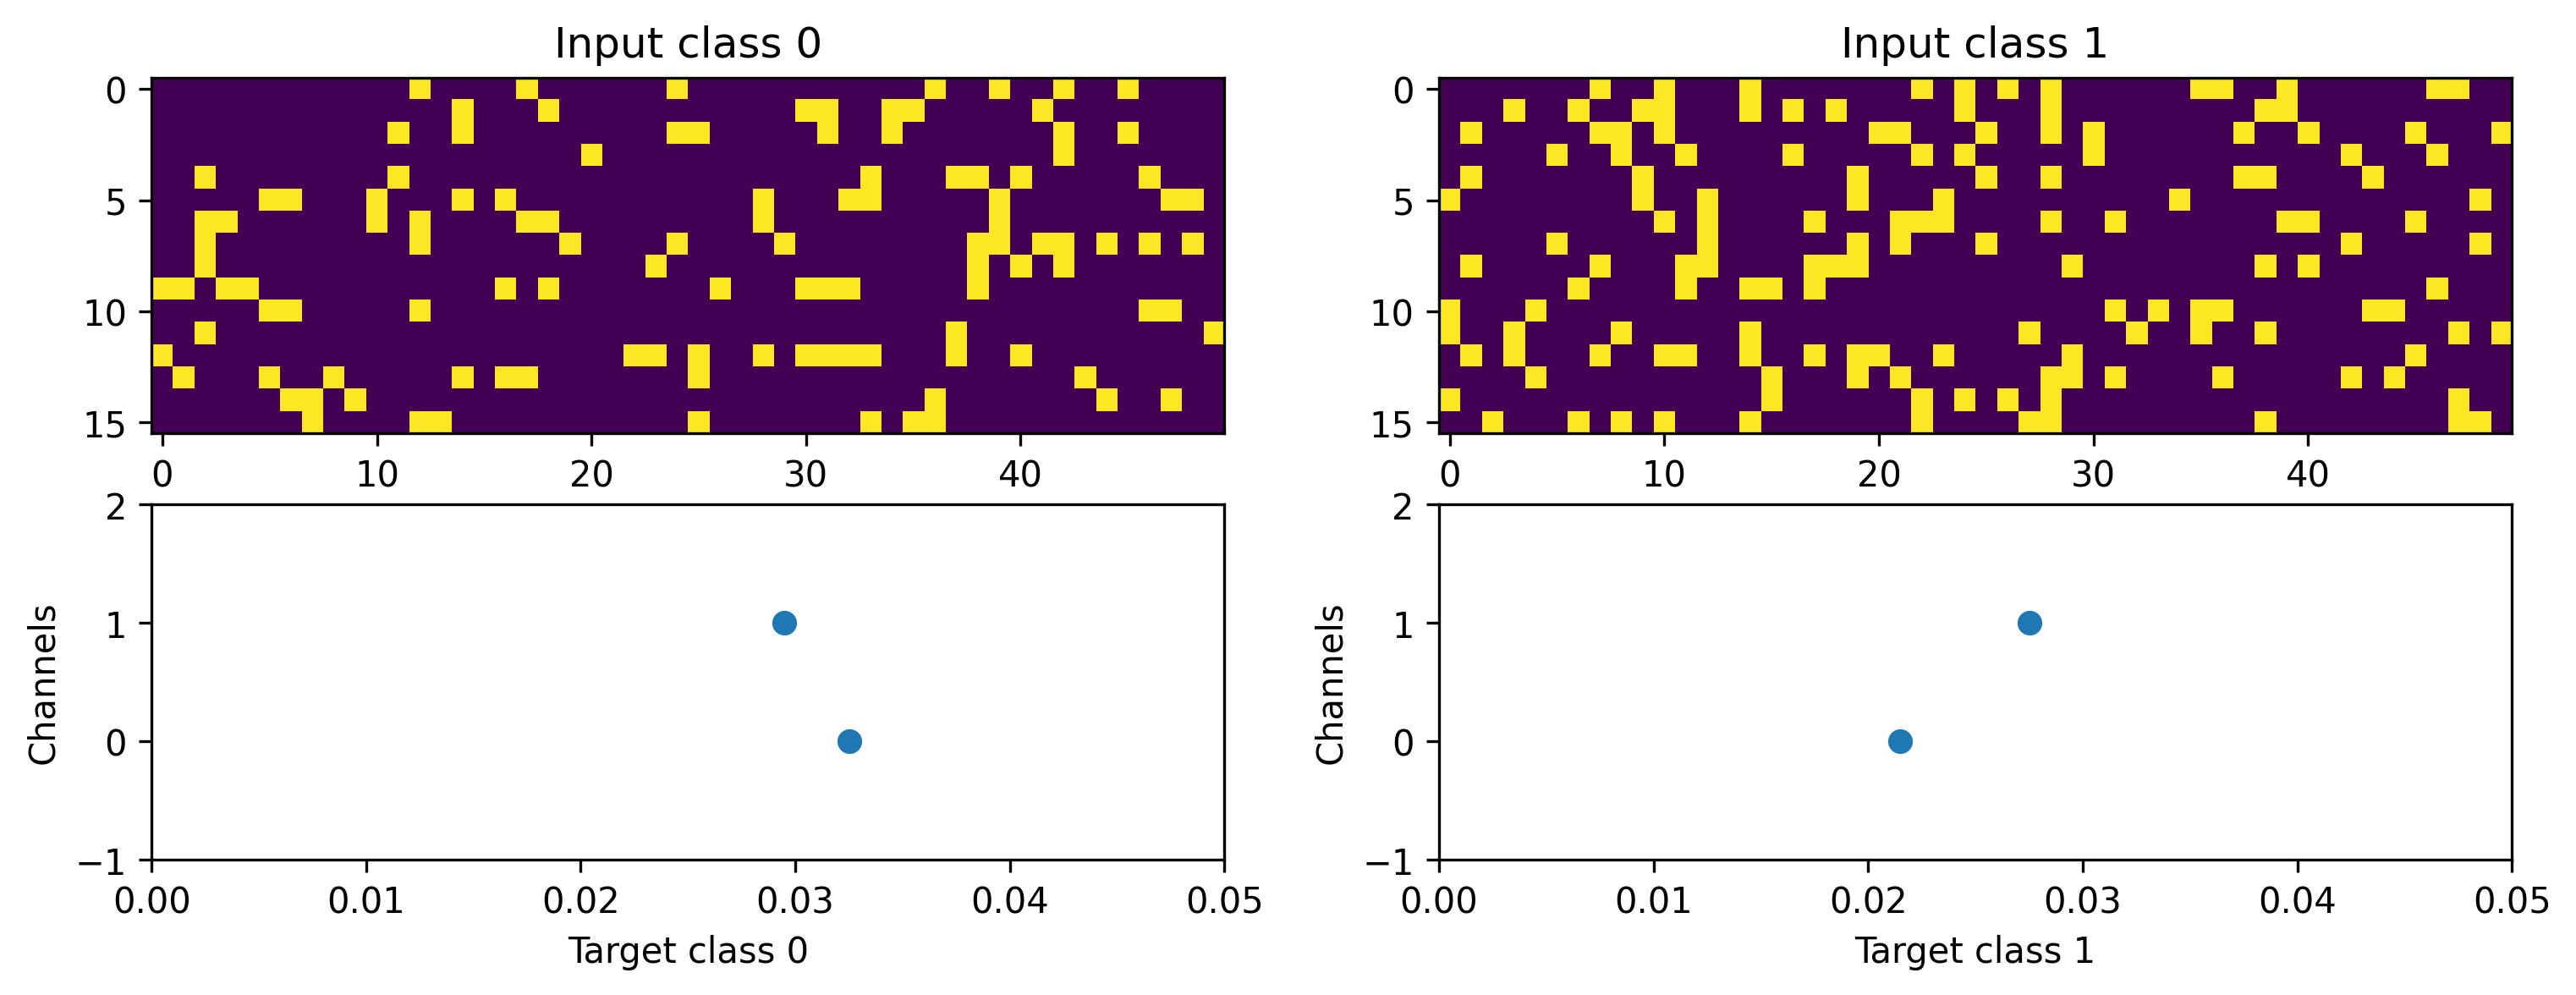

In [7]:
# - Instantiate a dataset
Nin = 16
Nout = 2
num_classes = 2
T = 50
dt = 1e-3
ds = MultiClassRandomSpikeTimeMapping(
    num_classes=num_classes,
    input_channels=Nin,
    target_channels=Nout,
    sample_length=T,
)

# Display the dataset classes
plt.figure()
for i, sample in enumerate(ds):
    plt.subplot(2, len(ds), i + 1)
    plt.imshow(sample[0].T, aspect="auto", interpolation="None")
    plt.title(f"Input class {i}")

    plt.subplot(2, len(ds), i + len(ds) + 1)
    TSEvent.from_raster(sample[1], dt=dt).plot()
    plt.xlabel(f"Target class {i}")

## Define a network

We'll define a very simple MLP-like network to solve the spike timing task. We define 3 layers, input, hidden and output of which all are spiking. To demonstrate the aliasing capabilities of Xylo we also include a residual block over the hidden layers. We'll use the rockpool torch modules

In [8]:
from torch.nn import Linear, Tanh
from rockpool.nn.modules import LIFBitshiftTorch
from rockpool.nn.modules import TorchModule, LinearTorch
from rockpool.nn.combinators import Sequential, Residual
from rockpool import TSContinuous
from rockpool.parameters import Constant
from rockpool.nn.modules.torch.lif_torch import PeriodicExponential
import copy

Nhidden = 63

net = Sequential(
    LinearTorch((Nin, Nhidden), has_bias=False),
    LIFBitshiftTorch(
        (Nhidden),
        tau_mem=0.002,
        tau_syn=0.002,
        bias=Constant(0),
        dt=dt,
        spike_generation_fn=PeriodicExponential,
    ),
    Residual(
        LinearTorch((Nhidden, Nhidden), has_bias=False),
        LIFBitshiftTorch(
            (Nhidden),
            tau_mem=0.002,
            tau_syn=0.002,
            bias=Constant(0),
            dt=dt,
            spike_generation_fn=PeriodicExponential,
        ),
    ),
    LinearTorch((Nhidden, Nout), has_bias=False),
    LIFBitshiftTorch(
        (Nout),
        tau_mem=0.002,
        tau_syn=0.002,
        bias=Constant(0),
        dt=dt,
        spike_generation_fn=PeriodicExponential,
    ),
)
net

TorchSequential  with shape (16, 2) {
    LinearTorch '0_LinearTorch' with shape (16, 63)
    LIFBitshiftTorch '1_LIFBitshiftTorch' with shape (63, 63)
    TorchResidual '2_TorchResidual' with shape (63, 63) {
        LinearTorch '0_LinearTorch' with shape (63, 63)
        LIFBitshiftTorch '1_LIFBitshiftTorch' with shape (63, 63)
    }
    LinearTorch '3_LinearTorch' with shape (63, 2)
    LIFBitshiftTorch '4_LIFBitshiftTorch' with shape (2, 2)
}

## Training loop

As usually done for a regression task, we are using the MSE loss and Adam during training.
Everything works exactly the same as for the non-spiking layers with the exception that we are resetting the state of the neurons after each sameple using the `detach` function.

In [9]:
# - Useful imports
from tqdm.autonotebook import tqdm
from torch.optim import Adam, SGD
from torch.nn import MSELoss

# - Get the optimiser functions
optimizer = Adam(net.parameters().astorch(), lr=1e-2)

# - Loss function
loss_fun = MSELoss()

# - Record the loss values over training iterations
loss_t = []

num_epochs = 1000
iterator = tqdm(range(num_epochs))
# - Loop over iterations
for i in iterator:
    epoch_loss = 0
    for input, target in ds:

        net.reset_state()
        optimizer.zero_grad()

        output, _, record = net(input.unsqueeze(0), record=True)

        loss = loss_fun(output, target.unsqueeze(0))

        if loss.item() > 0:
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()

    # - Keep track of the loss
    loss_t.append(epoch_loss)
    if epoch_loss == 0:
        iterator.close()
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

After training, we inspect the loss and plot the result of the training. The loss is very noisy but is getting to 0 after a while. Also the output spikes matches the target, if that's not the case, please retrain.

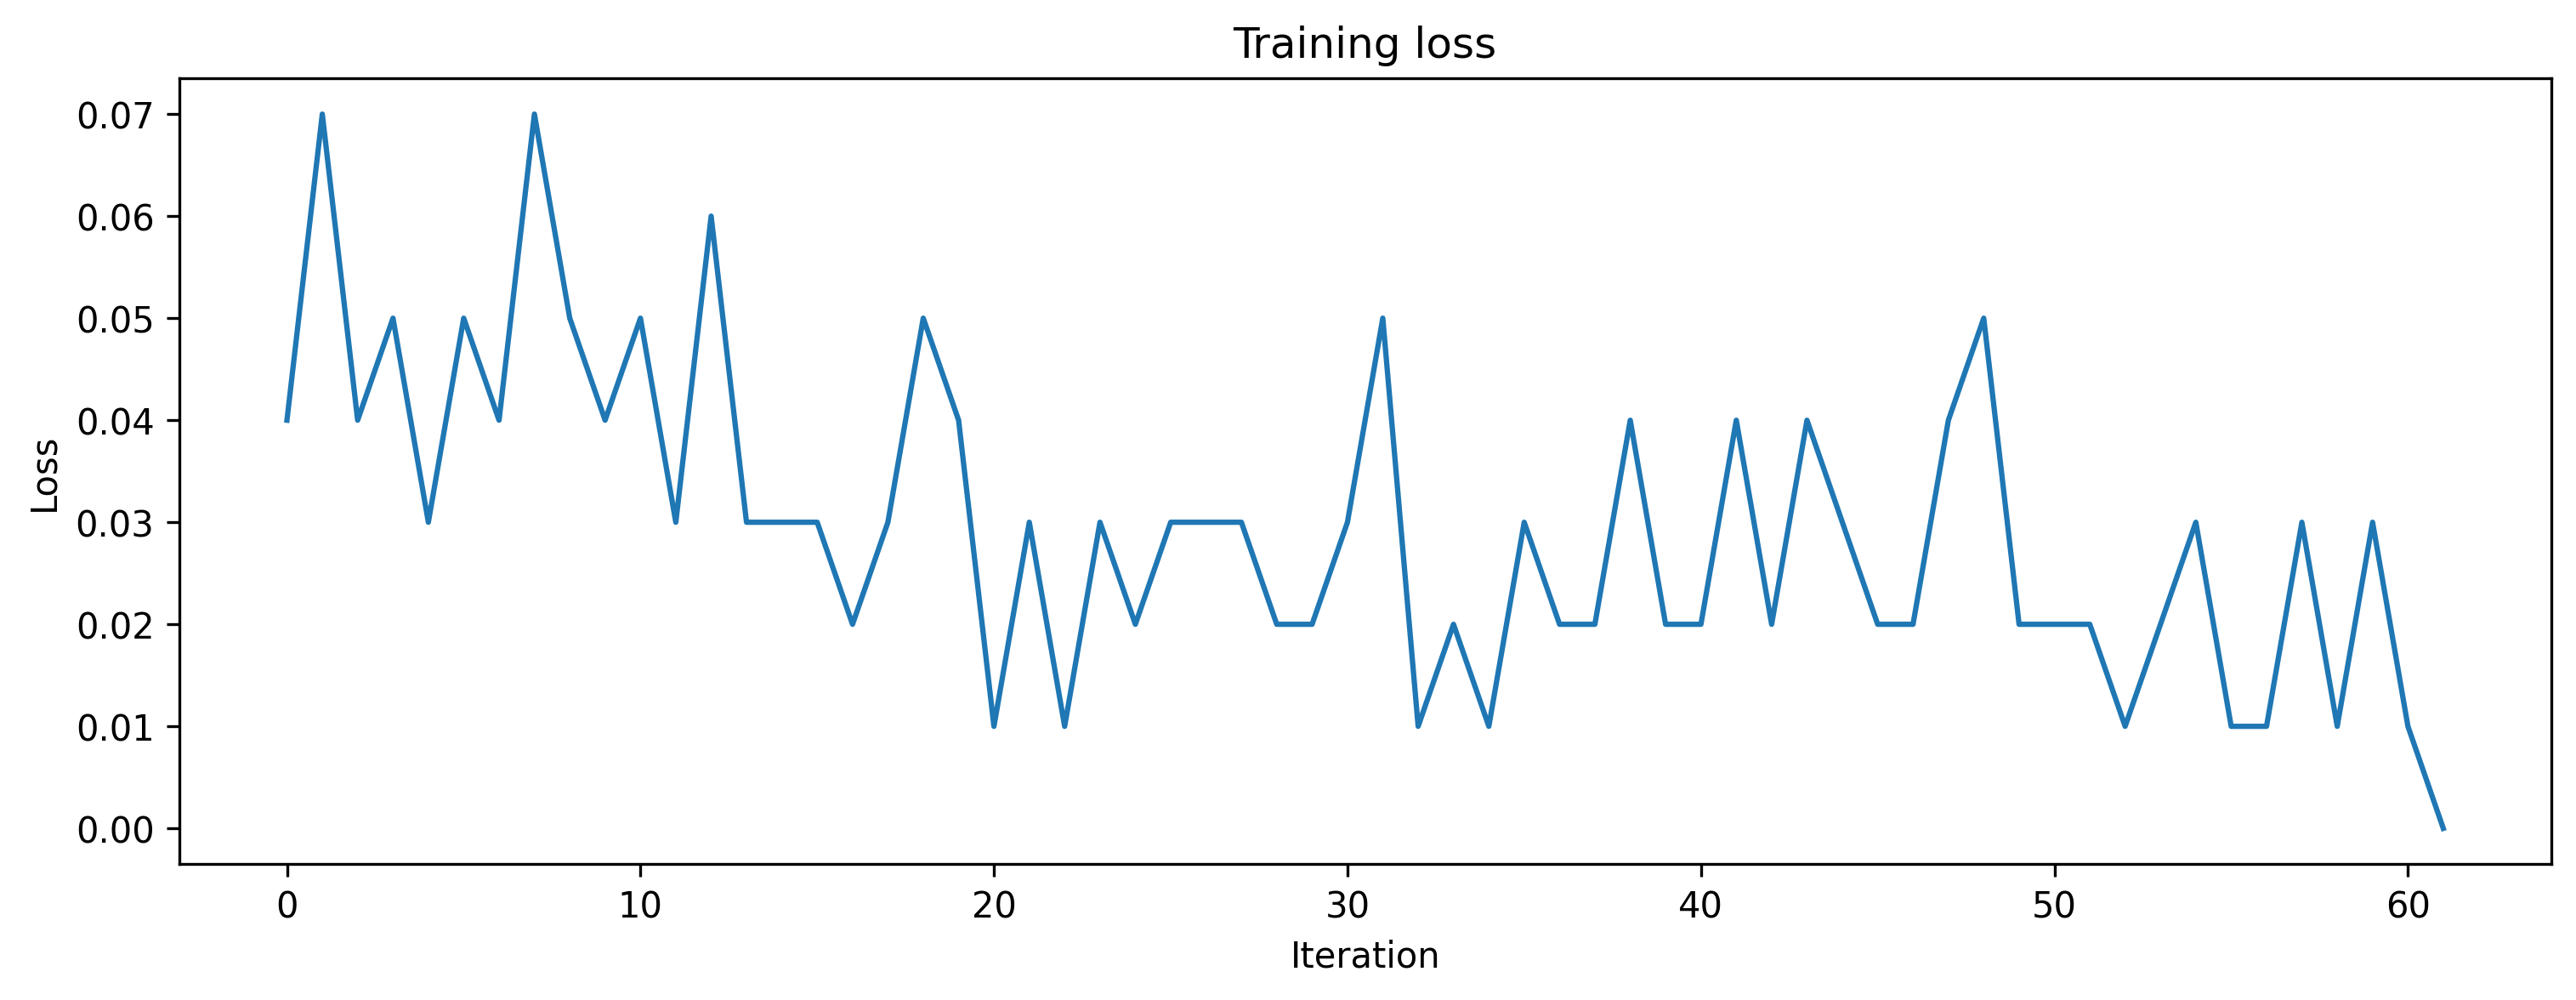

In [10]:
# - Plot the loss over iterations
plt.plot(loss_t)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training loss");

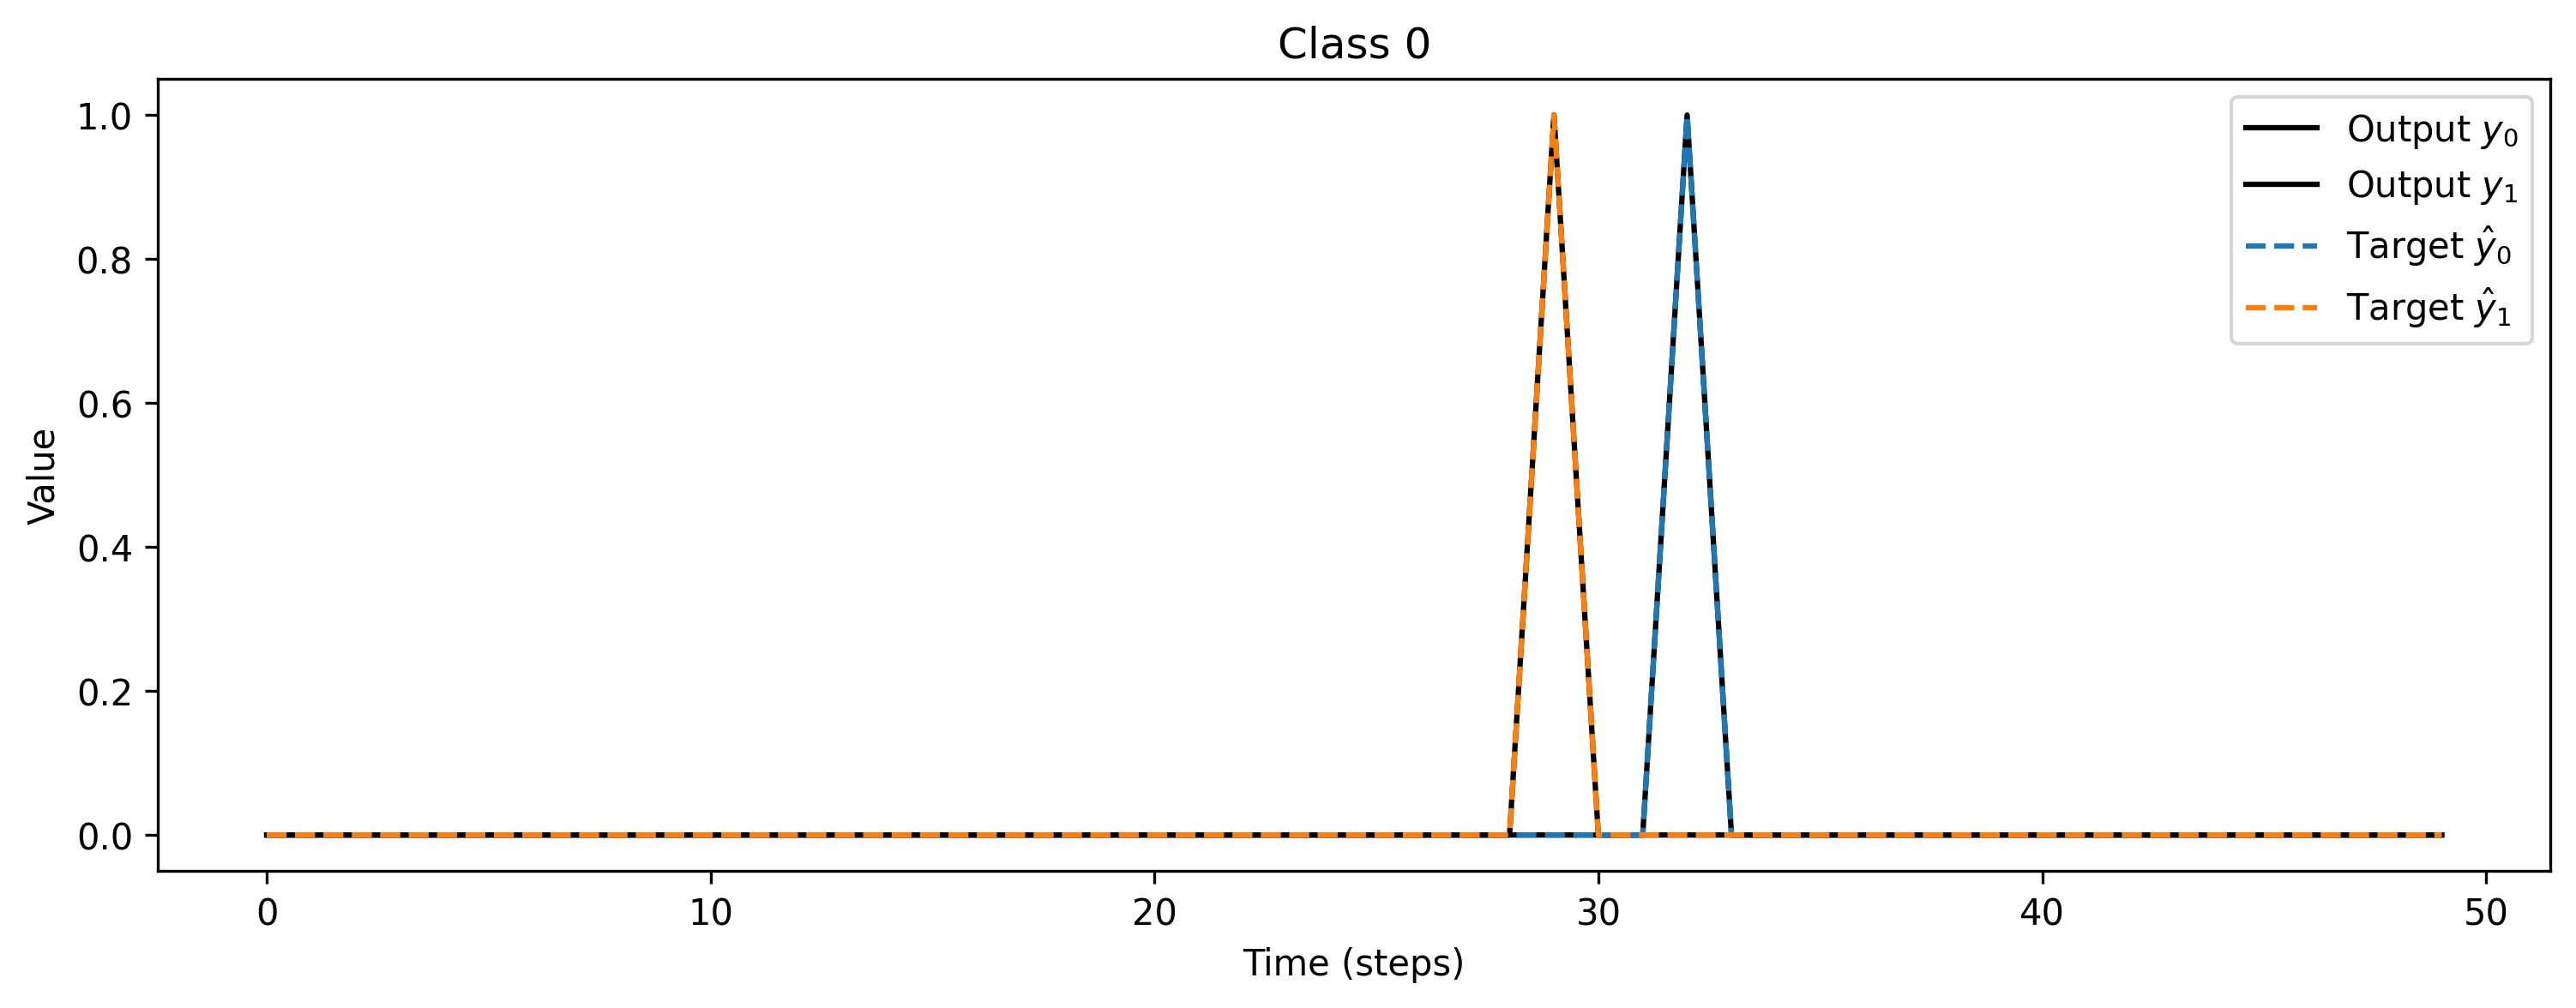

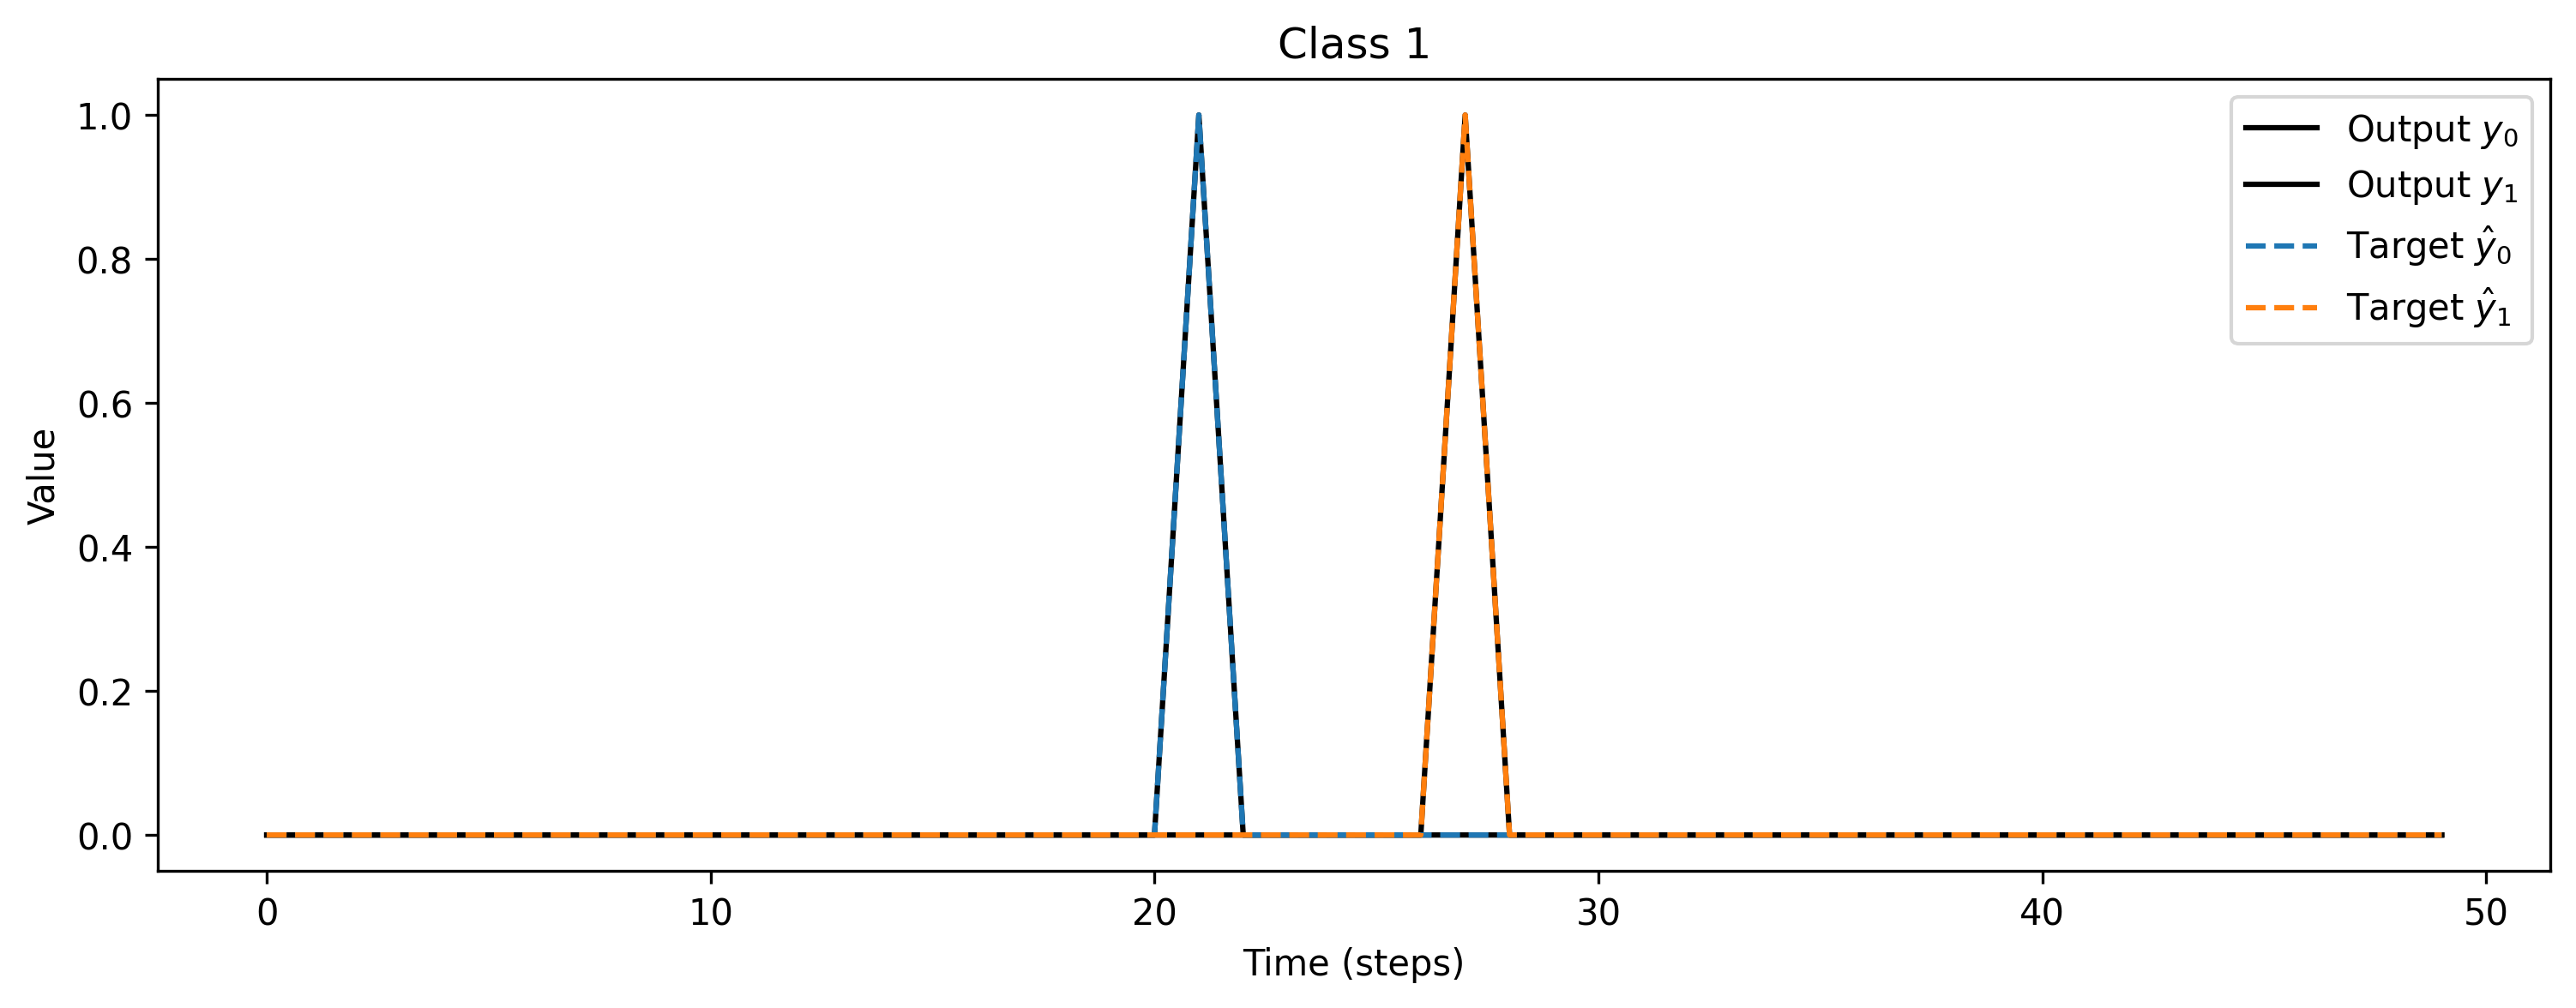

In [11]:
# - Evaluate classes
for i_class, [input, target] in enumerate(ds):

    # - Evaluate network
    net = net.reset_state()

    output, _, rec_float = net(input.unsqueeze(0), record=True)

    # - Plot output and target
    plt.figure()
    plt.plot(output.detach().cpu().squeeze().numpy(), "k-")
    plt.plot(target, "--")
    plt.xlabel("Time (steps)")
    plt.ylabel("Value")
    plt.legend(
        [
            "Output $y_0$",
            "Output $y_1$",
            "Target $\hat{y}_0$",
            "Target $\hat{y}_1$",
        ]
    )
    plt.title(f"Class {i_class}")

## Deploying this network to XyloSim

Now that the network learned this simple task, we can try to run it in a simulation of Xylo.
Remember, Xylo has some limitations:
- Neurons
    - 16 input channels
    - 1000 recurrently connected neurons
    - 8 output channels

- Connectivity
    - Fanout between input and recurrent layer is unlimited
    - Fanout between recurrent neurons is maximally 63
    - Fanout between recurrent and output neurons is unlimited
    - Aliases (skip connections) only in direction of increasing neuron id

- Neuron model
    - Quantized Leaky Integrate and Fire
    - 16 bit membrane potential
    - 16 bit synaptic current
    - 8 bit weights
    - 4 bit bitshift decay for membrane and synapses
    - special: possibly 2 synapses per neuron

- Simulation
    - Integration method:
        - Forward euler, resolution between 1 ms and 10 ms
        
   
For details, please take a look at the XyloSpecs and the documentation of Samna.

In order to run our model on Xylo, we have to fulfill those requirements. The SNN in this example already fulfills the connectivtiy and neuron requirements. Moreover, the Torch-based LIFBitshiftTorch in rockpool already simulates the bitshift decay (which is one of the reasons why it is so slow). So the main difficulty is to bring the parameters to the correct format and also to quantize the weights and thresholds to 8 resp. 16 bit.

For that we use the graph representation of our network and use the mapper function to get the specs for Xylo.

In [12]:
from rockpool.devices import xylo as x

spec = x.vA2.mapper(net.as_graph(), weight_dtype="float")
print(spec["weights_in"])

[[ 0.59885234  0.50180435 -0.03617156 ...  0.          0.
   0.        ]
 [-0.62043732 -0.41995907 -0.26439306 ...  0.          0.
   0.        ]
 [-0.0106684  -0.22030173 -0.36956164 ...  0.          0.
   0.        ]
 ...
 [-0.44258305 -0.00969374  0.46318182 ...  0.          0.
   0.        ]
 [-0.33629036  0.29419792 -0.49661916 ...  0.          0.
   0.        ]
 [ 0.75882936  0.26578194  0.36984292 ...  0.          0.
   0.        ]]

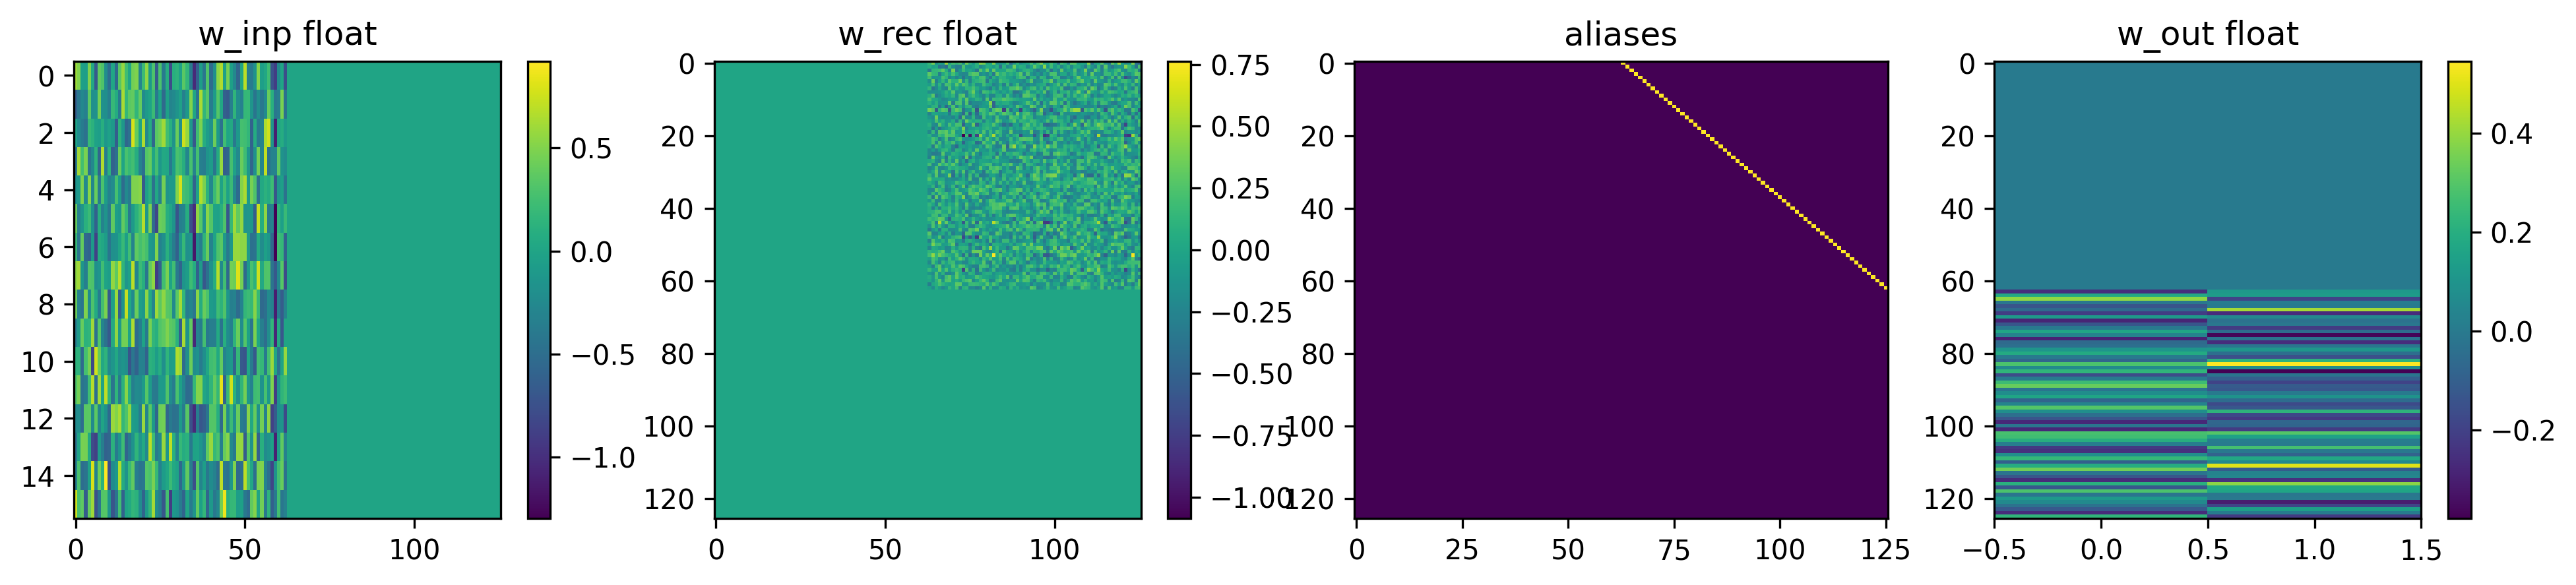

In [13]:
w_inp_float = spec["weights_in"]
w_rec_float = spec["weights_rec"]
w_out_float = spec["weights_out"]
aliases = spec["aliases"]

fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(141)
ax.set_title("w_inp float")
im = ax.imshow(w_inp_float[:, :], aspect="auto", interpolation="None")
plt.colorbar(im)

ax = fig.add_subplot(142)
ax.set_title("w_rec float")
im = ax.imshow(w_rec_float[:, :], aspect="auto", interpolation="None")
plt.colorbar(im)

ax = fig.add_subplot(143)
ax.set_title("aliases")
aliases_ = np.zeros_like(w_rec_float[:, :])
for i, a in enumerate(aliases):
    if len(a) > 0:
        aliases_[i, a[0]] = 1
im = ax.imshow(aliases_, aspect="auto", interpolation="None")

ax = fig.add_subplot(144)
ax.set_title("w_out float")
im = ax.imshow(w_out_float, aspect="auto", interpolation="None")
plt.colorbar(im);

As can be seen, the input weight matrix has a dimension of (16, 63) and contains the weights of the first linear layer of the model.

The recurrent weight matrix is nonzero in the top-right quarter, reflecting that the first 63 neurons connect to the next 63 neurons (filled with the weights on the second linear layer of the model). Note that there are no recurrent connections as the diagonal blocks are all zero.

In the model we defined a skip connection skipping the hidden layer. In Torch that's easily done by the + operator, adding the activations of one layer to another and hence skipping the layers in between (the dimensions must be compatible). We get the same behavior in Xylo using aliases. If neuron 'a' has alias 'b' means that the spike count of 'b' is increased by the spike count of 'a'. In our case, we aliased the input neurons to the hidden neurons to add up their activations.

The output weight matrix connects the second population to the output, hence there are non-zero values for the last 63 neurons to the two output neurons.

The time-constants for the exponential decay are less exciting; they are all 2 ms. But this timeconstant has to be translated to values for bit-shift decay (dash). The equation for that is:

$dash = [\log_2(\tau / dt)]$

Hence, a timeconstant of 2ms with a simulation resolution of 1 ms is 1.

But what is done with this bitshift of 1? Let's have an example and compare exponential decay to bitshift decay.

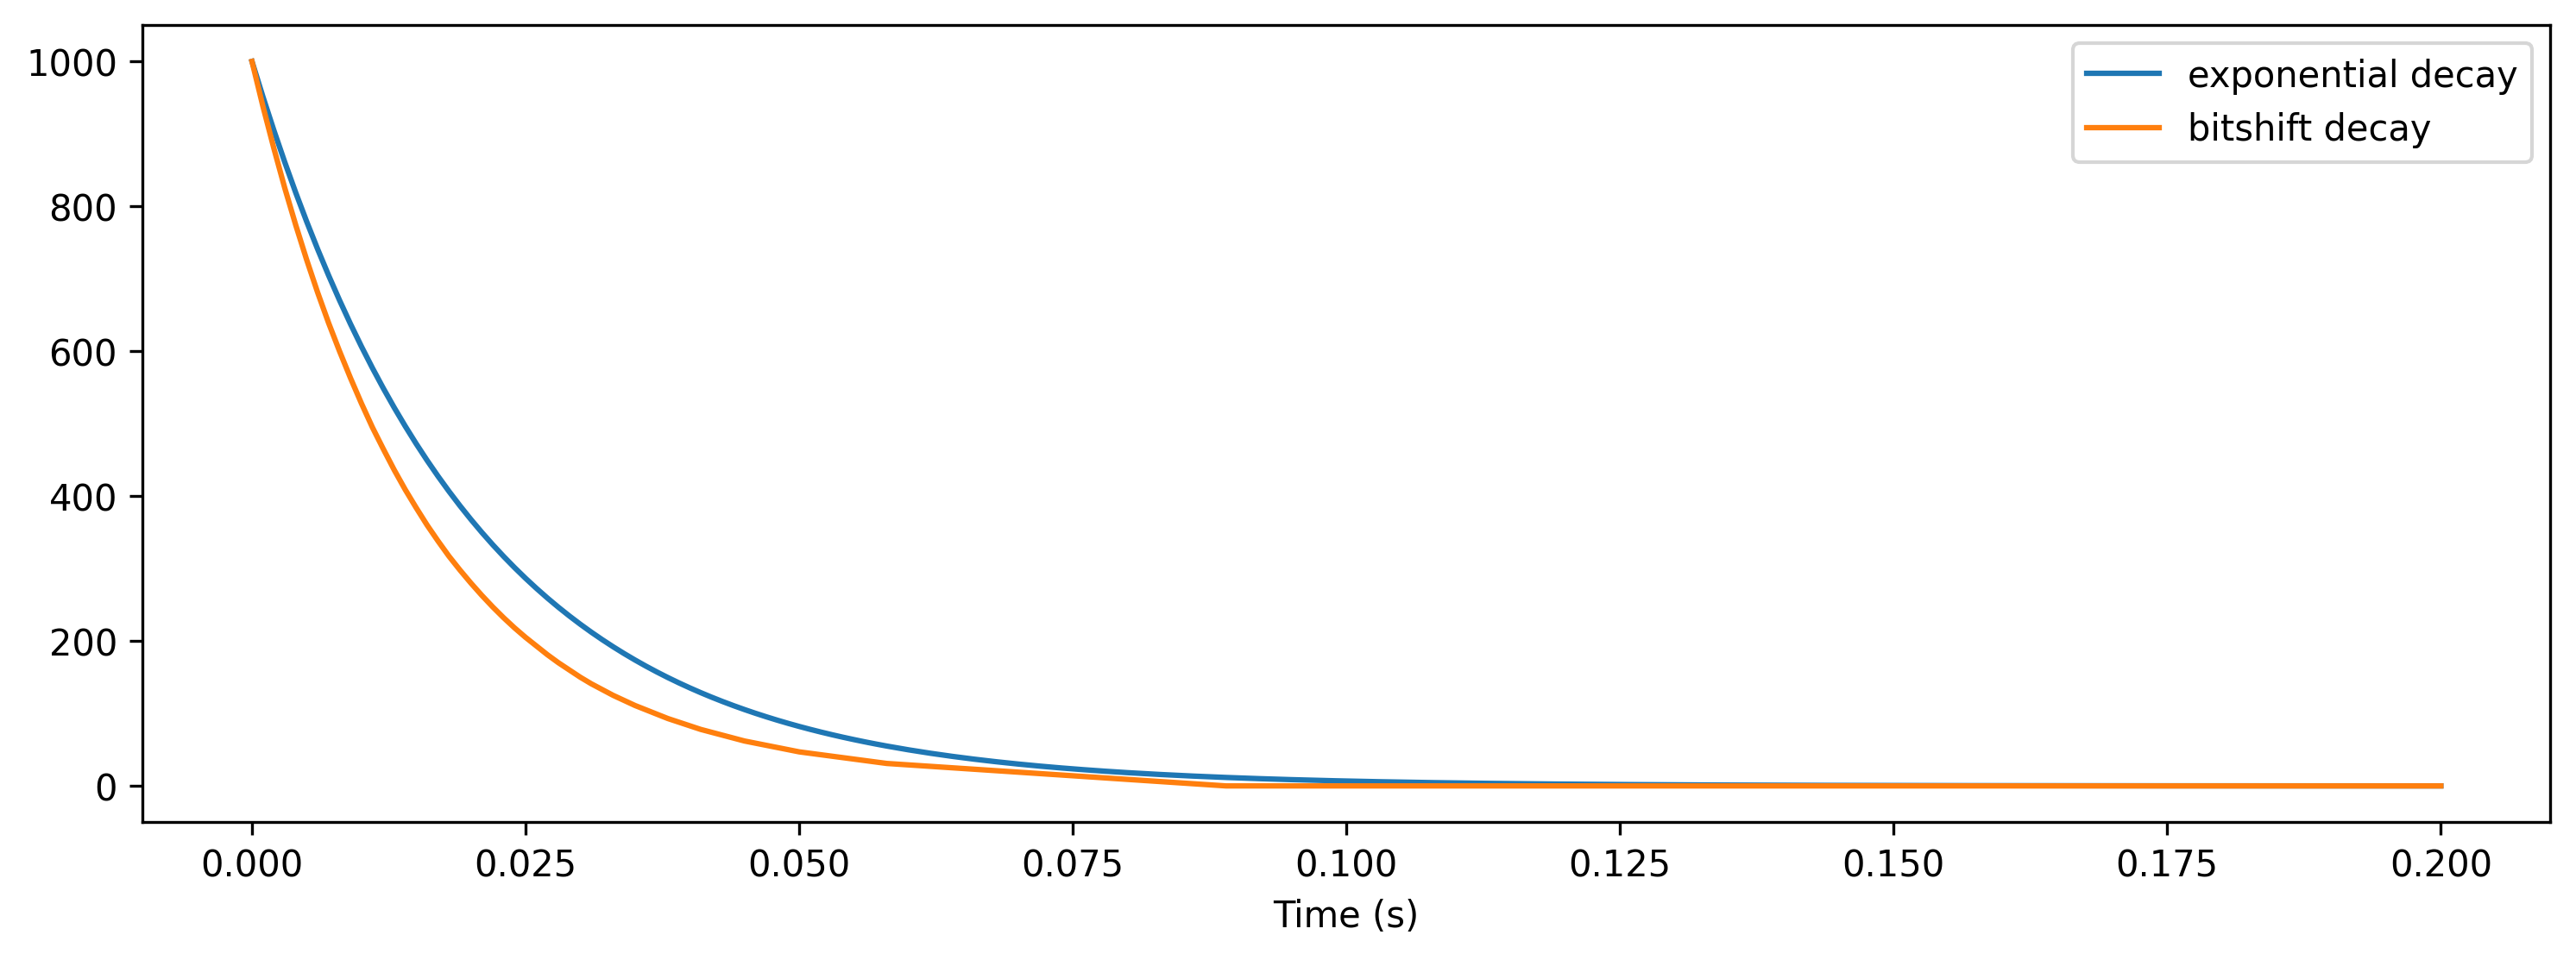

In [14]:
tau = 20e-3  # 20 ms
dt_ = 1e-3  # 1 ms resolution

dash = np.round(np.log2(tau / dt_)).astype(int)
exp_propagator = np.exp(-dt_ / tau)

simtime = 0.2  # 1 sec
t_ = 0
v_tau = [1000]
v_dash = [1000]
while t_ < simtime:
    v_tau.append(v_tau[-1] * exp_propagator)
    if (v_dash[-1] >> dash) > 0:
        v_dash.append(v_dash[-1] - (v_dash[-1] >> dash))
    else:
        v_dash.append(int(np.clip(v_dash[-1] - 1, 0, np.inf)))
    t_ += dt_

plt.plot(np.arange(0, len(v_tau)) * dt_, v_tau, label="exponential decay")
plt.plot(np.arange(0, len(v_dash)) * dt_, v_dash, label="bitshift decay")
plt.legend()
plt.xlabel("Time (s)");

As clearly visible, the bitshift decay behaves similar to an exponential decay but poses limitations on time-constants and resolution. Even worse, SNNs are very sensitive on the time-constants and hence even those 'small' differences can change the dynamics in the network drastically.
BUT bitshifts are extremely cheap to compute and put into hardware which is the main reason we are using them on Xylo.

Now, let's investigate the quantization of weights. We use the following function:

In [15]:
from rockpool.transform import quantize_methods as q

quant_spec = spec.copy()
del quant_spec["mapped_graph"]
del quant_spec["dt"]
quant_spec.update(q.global_quantize(**quant_spec))
print(quant_spec["weights_in"])

[[ 59  49  -4 ...   0   0   0]
 [-61 -41 -26 ...   0   0   0]
 [ -1 -22 -36 ...   0   0   0]
 ...
 [-43  -1  45 ...   0   0   0]
 [-33  29 -49 ...   0   0   0]
 [ 74  26  36 ...   0   0   0]]

Now. let's visualize the quantized weight in comparison to the floating point weights.

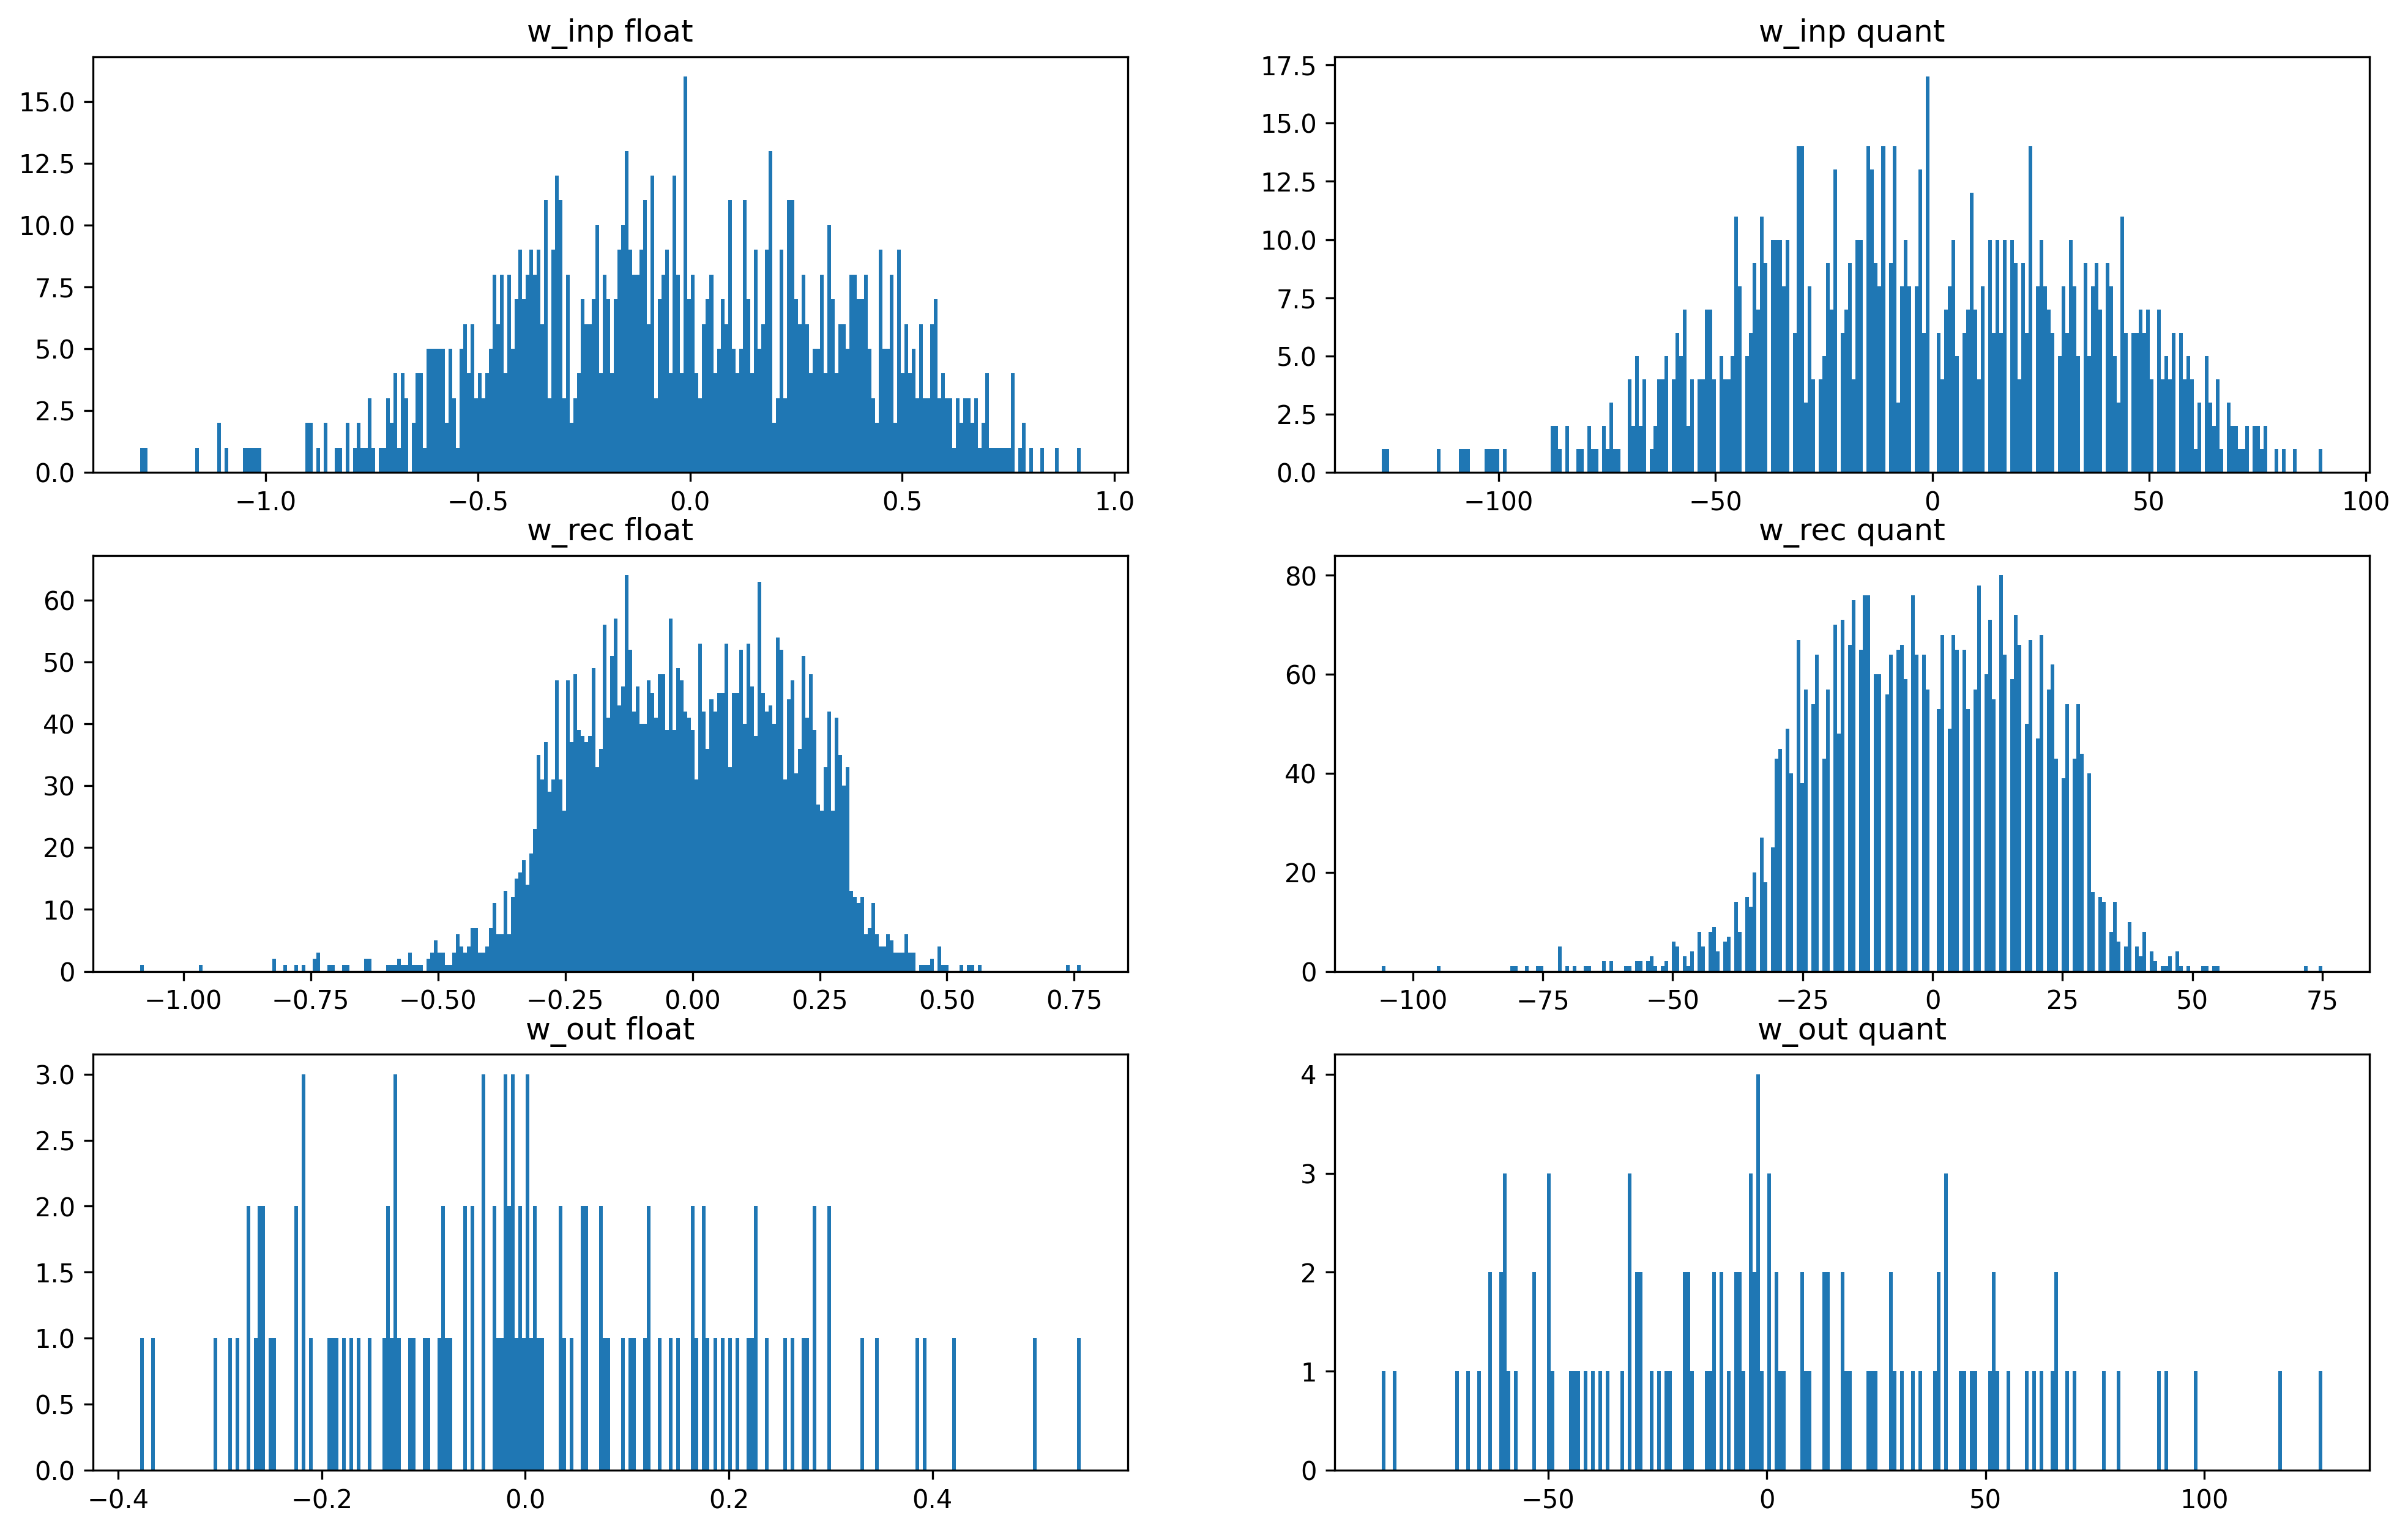

In [16]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(321)
ax.set_title("w_inp float")
ax.hist(np.ravel(w_inp_float[w_inp_float != 0]), bins=2**8)

ax = fig.add_subplot(322)
ax.set_title("w_inp quant")
ax.hist(np.ravel(quant_spec["weights_in"][quant_spec["weights_in"] != 0]), bins=2**8)

ax = fig.add_subplot(323)
ax.set_title("w_rec float")
ax.hist(np.ravel(w_rec_float[w_rec_float != 0]), bins=2**8)

ax = fig.add_subplot(324)
ax.set_title("w_rec quant")
ax.hist(
    np.ravel(quant_spec["weights_rec"][quant_spec["weights_rec"] != 0]), bins=2**8
)

ax = fig.add_subplot(325)
ax.set_title("w_out float")
ax.hist(np.ravel(w_out_float[w_out_float != 0]), bins=2**8)

ax = fig.add_subplot(326)
ax.set_title("w_out quant")
ax.hist(
    np.ravel(quant_spec["weights_out"][quant_spec["weights_out"] != 0]), bins=2**8
);

As you can see, the floating point weights all below 0 while the quantized weights got scaled to be between -128 and +127. In this case, we are lucky and the distribution of weights look very similar.
Unlucky cases would be:
- Weight distribution is not centered around 0
- A few very strong weights
- Non-flat distribution

In all those 'unlucky' cases, the quantized weights could not make use of the complete range and might the resulting network behavior might be very different compared with the floating point network. There might be 'tricks' to avoid those situations.

In this case, though, everything looks fine. So let's go to the next step and create a xylo configuration and simulate that network.

In [29]:
from rockpool.devices.xylo.syns61201 import config_from_specification

xylo_conf, is_valid, message = config_from_specification(**quant_spec)
print("Valid config: ", is_valid)

Valid config:  True

In [30]:
from rockpool.devices.xylo.syns61201 import XyloSim
from rockpool.timeseries import TSEvent

In [31]:
sim = XyloSim.from_config(xylo_conf, dt=dt).timed(add_events=True)

ModuleNotFoundError: Missing the `xylosim, samna` backend. `XyloSim` objects, and others relying on `xylosim, samna` are not available.

In [ ]:
# - Evaluate classes
for i_class, [input, target] in enumerate(ds):

    sim.reset_state()
    sim.reset_time()
    inp = TSEvent.from_raster(input.cpu().numpy(), dt=dt, t_start=0)
    output, _, rec_sim = sim(inp, record=True)

    # - Plot output and target
    plt.figure()
    output.plot()
    plt.plot(np.arange(len(target)) * dt, target, "--")
    plt.xlabel("Time (s)")
    plt.ylabel("Value")

    plt.ylim([0, target.max()])
    plt.title(f"Class {i_class}")

As you can see, the quantized model still spikes at the same times as the floating point model (see figure after training). Let's briefly compare the internal dynamics.

In [ ]:
fig = plt.figure(figsize=(16, 25))

ax = fig.add_subplot(5, 2, 1)
plt.plot(rec_float["1_LIFBitshiftTorch"]["isyn"].squeeze(0).squeeze(-1).detach())
plt.plot(
    rec_float["2_TorchResidual"]["1_LIFBitshiftTorch"]["isyn"]
    .squeeze(0)
    .squeeze(-1)
    .detach()
)
ax.set_title("Isyn inp / hidden float")

ax = fig.add_subplot(5, 2, 2)
rec_sim["Isyn"].plot()
ax.set_title("Isyn recurrent layer quant")

ax = fig.add_subplot(5, 2, 3)
plt.plot(rec_float["1_LIFBitshiftTorch"]["vmem"].squeeze(0).squeeze(-1).detach())
plt.plot(
    rec_float["2_TorchResidual"]["1_LIFBitshiftTorch"]["vmem"]
    .squeeze(0)
    .squeeze(-1)
    .detach()
)
ax.set_title("Vmem inp / hidden float")

ax = fig.add_subplot(5, 2, 4)
rec_sim["Vmem"].plot()
ax.set_title("Vmem recurrent layer quant")

ax = fig.add_subplot(5, 2, 5)
spk_float = np.vstack(
    [
        rec_float["1_LIFBitshiftTorch"]["spikes"].squeeze(0).detach().T,
        rec_float["2_TorchResidual"]["1_LIFBitshiftTorch"]["spikes"]
        .squeeze(0)
        .detach()
        .T,
    ]
)
nids, times = np.where(spk_float)
plt.scatter(times, nids, s=1)
ax.set_title("spikes inp / hidden float")

ax = fig.add_subplot(5, 2, 6)
rec_sim["Spikes"].plot(s=1)
plt.scatter(times, nids, s=1)
ax.set_title("spikes recurrent layer quant")

ax = fig.add_subplot(5, 2, 7)
plt.plot(rec_float["4_LIFBitshiftTorch"]["isyn"].squeeze(0).squeeze(-1).detach())
ax.set_title("Isyn output float")

ax = fig.add_subplot(5, 2, 8)
rec_sim["Isyn_out"].plot()
ax.set_title("Isyn output quant")

ax = fig.add_subplot(5, 2, 9)
plt.plot(rec_float["4_LIFBitshiftTorch"]["vmem"].squeeze(0).squeeze(-1).detach())
ax.set_title("Vmem output float")

ax = fig.add_subplot(5, 2, 10)
rec_sim["Vmem_out"].plot()
ax.set_title("Vmem output quant");

Although it's probably hard to see as there are so many neurons, the dynamics within the networks look very similar. 

## Deploy to Xylo

In the next step, we want to take this trained network and deploy it on the Xylo hardware. From our XyloSim simulation, we know already that the network will run on Xylo and should produce the same results. Hence, the transfer is easy and straight forward.

First step is to plug in the hardware using the USB-C cable and ask `samna` to find the board.

In [ ]:
import samna

samna.init_samna()

In [ ]:
from rockpool.devices.xylo import xylo_devkit_utils as xu

xylo_hdk_nodes = xu.find_xylo_boards(samna.device_node)
xylo_hdk_nodes

Now, we can use the same configuration for Xylo as we did before for XyloSim.

In [ ]:
modSamna = x.XyloSamna(xylo_hdk_nodes[0], xylo_conf, dt=dt).timed()

We can also run the network on Xylo in the same way and see that Xylo produces the same output as XyloSim did.

In [ ]:
# - Evaluate classes
for i_class, [input, target] in enumerate(ds):

    modSamna.reset_state()
    modSamna.reset_time()
    inp = TSEvent.from_raster(input.cpu().numpy(), dt=dt, t_start=0)
    output, _, rec_sim = modSamna(inp, record=True)

    # - Plot output and target
    plt.figure()
    output.plot()
    plt.plot(np.arange(len(target)) * dt, target, "--")
    plt.xlabel("Time (s)")
    plt.ylabel("Value")

    plt.ylim([0, target.max()])
    plt.title(f"Class {i_class}")